### Code for Gradient Boost stacking using nested cross validation and hyperparmeter tuning

Loading and preparing data...
Dataset shape: (1039, 21)
Class distribution: {1: 530, 0: 509}
Training set shape: (883, 21)
Test set shape: (156, 21)
TEST SET IS NOW COMPLETELY ISOLATED - NO FURTHER ACCESS UNTIL FINAL EVALUATION

Setting up nested cross-validation to prevent hyperparameter leakage...
Performing nested cross-validation...
This ensures no data leakage between hyperparameter tuning and model evaluation
Processing outer fold 1/5...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fold 1 validation score: 0.7853
Processing outer fold 2/5...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fold 2 validation score: 0.8192
Processing outer fold 3/5...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fold 3 validation score: 0.7910
Processing outer fold 4/5...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fold 4 validation score: 0.7614
Processing outer fold 5/5...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fol

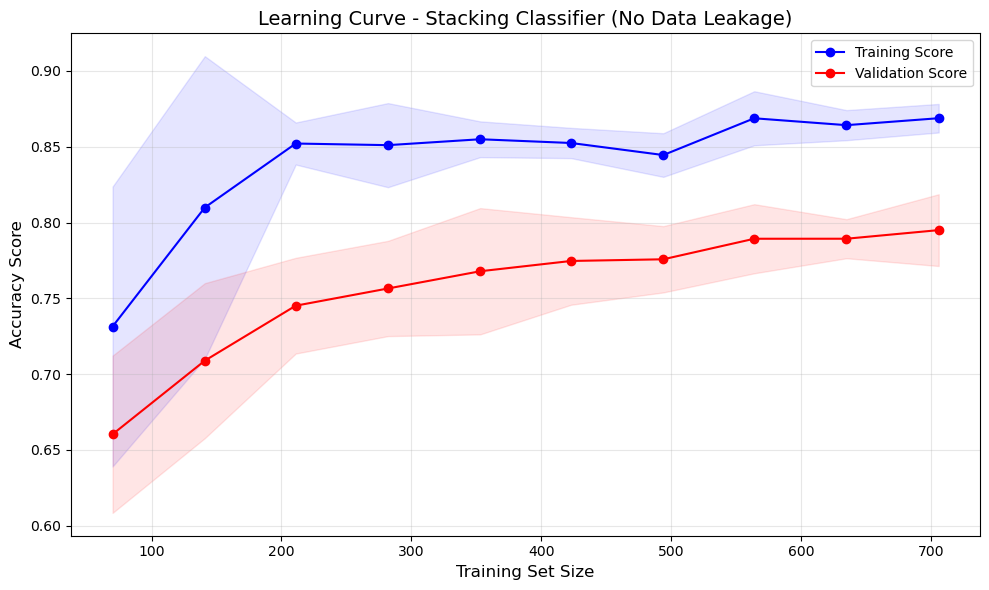


Analyzing feature importances...

Meta-Model Feature Importances:
(Shows how much the meta-learner relies on each base learner)
  LGBM: 0.6943
   XGB: 0.2560
    LR: 0.0300
    RF: 0.0197

BASE LEARNER FEATURE IMPORTANCES:

LR Coefficients (absolute values):
eTh           0.525446
ZR            0.495410
TREE          0.365884
CAO           0.339963
Lin_order2    0.326940
BA            0.141610
Geol          0.118506
Dol_den       0.105463
RTP           0.083691
eK            0.078474
dtype: float64

RF Feature Importances:
BA      0.141316
eTh     0.133536
TREE    0.128202
ZR      0.124825
CE      0.099562
TH      0.076012
eK      0.046620
eU      0.040013
RB      0.031784
U       0.028600
dtype: float64

XGB Feature Importances:
TREE          0.237229
ZR            0.204037
eTh           0.070234
BA            0.049470
RB            0.043065
K2O           0.039742
MGO           0.031397
TH            0.031282
Lin_order2    0.029812
CE            0.029779
dtype: float32

LGBM Feature 

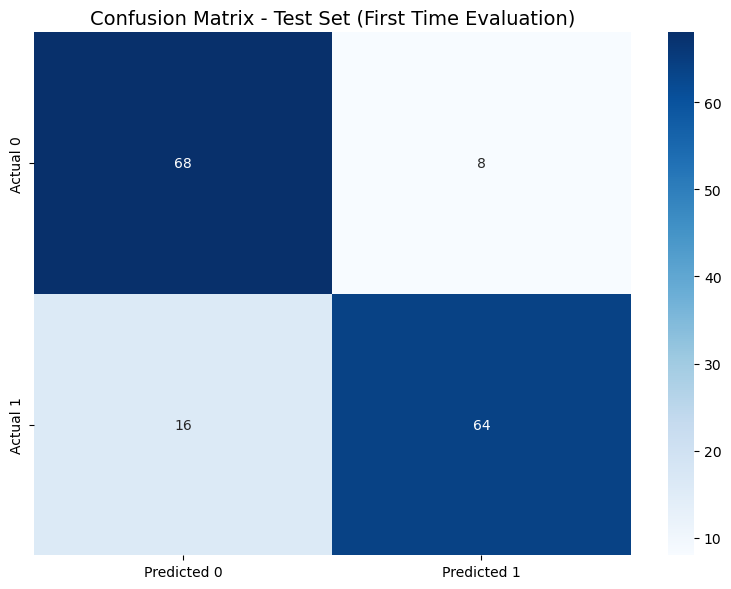


PERFORMANCE SUMMARY - NO DATA LEAKAGE
Nested CV Performance (Unbiased): 0.7961 ± 0.0230
Training CV Performance:          0.7961 ± 0.0221
Test Set Performance:             0.8462


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_validate,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------------
# 1. Load & Prepare Data
# -----------------------------
print("Loading and preparing data...")
df = pd.read_csv('ext_3k_SS01.csv', delimiter=',')
df['Label'] = 0
df.loc[:529, 'Label'] = 1

y = df['Label']
X_raw = df.iloc[:, 1:-1]  # Exclude first column (likely ID) and last column (Label)

# Apply log transformation to geochemical features (columns 6-20, 0-indexed)
geochem = X_raw.iloc[:, 6:21].apply(np.log1p)
other = X_raw.iloc[:, :6]
X = pd.concat([other, geochem], axis=1)
feature_names = X.columns.tolist()

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# -----------------------------
# 2. STRICT Train/Test Split - NO LEAKAGE
# -----------------------------
# CRITICAL: Test set is completely isolated from all training processes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42  # Increased test size
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("TEST SET IS NOW COMPLETELY ISOLATED - NO FURTHER ACCESS UNTIL FINAL EVALUATION")

# -----------------------------
# 3. PIPELINE APPROACH - PREVENTS SCALING LEAKAGE
# -----------------------------
# Create base learners as pipelines to ensure proper scaling within CV folds
def create_base_learners():
    """Create base learners with individual scaling pipelines"""
    
    base_learners = [
        ('lr', Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                penalty='l1', 
                C=0.1, 
                solver='liblinear', 
                max_iter=1000,
                random_state=42
            ))
        ])),
        
        ('rf', Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(
                n_estimators=100,
                max_depth=4, 
                min_samples_leaf=30, 
                random_state=42
            ))
        ])),
        
        ('xgb', Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', XGBClassifier(
                learning_rate=0.01,
                n_estimators=100,
                max_depth=4, 
                reg_alpha=8, 
                subsample=0.8,
                eval_metric='logloss',
                random_state=42,
                verbosity=0
            ))
        ])),
        
        ('lgbm', Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LGBMClassifier(
                boosting_type='gbdt', 
                n_estimators=500, 
                max_depth=7,
                reg_alpha=8, 
                colsample_bytree=0.3,
                random_state=42, 
                verbose=-1
            ))
        ]))
    ]
    
    return base_learners

# -----------------------------
# 4. NESTED CV SETUP - PREVENTS HYPERPARAMETER LEAKAGE
# -----------------------------
print("\nSetting up nested cross-validation to prevent hyperparameter leakage...")

# Outer CV for model evaluation (uses different random state)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inner CV for hyperparameter tuning (uses different random state)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Separate CV for stacking (uses different random state)
stacking_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=456)

# -----------------------------
# 5. HYPERPARAMETER TUNING WITH NESTED CV
# -----------------------------
def create_tuned_stacking_classifier():
    """Create stacking classifier with proper nested CV hyperparameter tuning"""
    
    # Base learners with pipelines
    estimators = create_base_learners()
    
    # Meta-learner pipeline (also with scaling)
    meta_learner = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
    
    # Create stacking classifier
    stacking_classifier = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_learner,
        cv=stacking_cv,  # Separate CV for stacking
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    # Hyperparameter grid for meta-learner
    param_grid = {
        'final_estimator__classifier__n_estimators': [50, 100, 200],
        'final_estimator__classifier__learning_rate': [0.05, 0.1, 0.2],
        'final_estimator__classifier__max_depth': [2, 3, 4]
    }
    
    # Grid search with inner CV
    grid_search = GridSearchCV(
        stacking_classifier,
        param_grid,
        cv=inner_cv,  # Inner CV for hyperparameter tuning
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    return grid_search

# -----------------------------
# 6. NESTED CROSS-VALIDATION EVALUATION
# -----------------------------
print("Performing nested cross-validation...")
print("This ensures no data leakage between hyperparameter tuning and model evaluation")

def nested_cv_evaluation(X_train, y_train):
    """Perform nested CV to get unbiased performance estimates"""
    
    nested_scores = []
    best_params_list = []
    
    fold_num = 1
    for train_idx, val_idx in outer_cv.split(X_train, y_train):
        print(f"Processing outer fold {fold_num}/5...")
        
        # Split data for this outer fold
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # Create and tune model on training portion
        tuned_model = create_tuned_stacking_classifier()
        tuned_model.fit(X_train_fold, y_train_fold)
        
        # Evaluate on validation portion
        val_score = tuned_model.score(X_val_fold, y_val_fold)
        nested_scores.append(val_score)
        best_params_list.append(tuned_model.best_params_)
        
        print(f"Fold {fold_num} validation score: {val_score:.4f}")
        fold_num += 1
    
    return nested_scores, best_params_list

# Perform nested CV
nested_scores, best_params_list = nested_cv_evaluation(X_train, y_train)

print(f"\nNested CV Results (Unbiased Performance Estimate):")
print(f"Mean Accuracy: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")
print(f"Individual fold scores: {[f'{score:.4f}' for score in nested_scores]}")

# -----------------------------
# 7. FINAL MODEL TRAINING
# -----------------------------
print("\nTraining final model on entire training set...")

# Train final model with best average parameters
final_model = create_tuned_stacking_classifier()
final_model.fit(X_train, y_train)

print(f"Final model best parameters: {final_model.best_params_}")
print(f"Final model training CV score: {final_model.best_score_:.4f}")

# -----------------------------
# 8. CROSS-VALIDATION ON TRAINING SET ONLY
# -----------------------------
print("\nPerforming final cross-validation on training set...")

# Get the best model from grid search
best_model = final_model.best_estimator_

# Perform CV evaluation
cv_results = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=outer_cv,  # Use outer CV for final evaluation
    scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
    return_train_score=False,  # Only validation scores to prevent leakage
    n_jobs=-1
)

print("\nCross-Validation Results on Training Set:")
print("=" * 50)
for metric in ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.upper():>10}: {scores.mean():.4f} ± {scores.std():.4f}")

# -----------------------------
# 9. LEARNING CURVE (NO LEAKAGE)
# -----------------------------
print("\nGenerating learning curve...")

train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=outer_cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

mean_train = train_scores.mean(axis=1)
std_train = train_scores.std(axis=1)
mean_val = val_scores.mean(axis=1)
std_val = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mean_train, 'o-', label='Training Score', color='blue')
plt.fill_between(train_sizes, mean_train - std_train, mean_train + std_train, alpha=0.1, color='blue')
plt.plot(train_sizes, mean_val, 'o-', label='Validation Score', color='red')
plt.fill_between(train_sizes, mean_val - std_val, mean_val + std_val, alpha=0.1, color='red')

plt.title('Learning Curve - Stacking Classifier (No Data Leakage)', fontsize=14)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 10. FEATURE IMPORTANCE ANALYSIS
# -----------------------------
print("\nAnalyzing feature importances...")

# Get the final trained stacking classifier
stacking_classifier = best_model

# Meta-learner feature importance
meta_model = stacking_classifier.final_estimator_.named_steps['classifier']
meta_importances = meta_model.feature_importances_

# Base learner names
base_learner_names = [name for name, _ in stacking_classifier.estimators]
meta_importance = pd.Series(meta_importances, index=base_learner_names)

print("\nMeta-Model Feature Importances:")
print("(Shows how much the meta-learner relies on each base learner)")
for name, importance in meta_importance.sort_values(ascending=False).items():
    print(f"{name.upper():>6}: {importance:.4f}")

# Base learner feature importances
print("\n" + "="*60)
print("BASE LEARNER FEATURE IMPORTANCES:")
print("="*60)

for name, estimator in stacking_classifier.named_estimators_.items():
    try:
        classifier = estimator.named_steps['classifier']
        
        if hasattr(classifier, 'feature_importances_'):
            print(f"\n{name.upper()} Feature Importances:")
            feature_imp = pd.Series(classifier.feature_importances_, 
                                   index=feature_names)
            print(feature_imp.sort_values(ascending=False).head(10))
        
        elif hasattr(classifier, 'coef_'):
            print(f"\n{name.upper()} Coefficients (absolute values):")
            coef_abs = pd.Series(np.abs(classifier.coef_[0]), 
                                index=feature_names)
            print(coef_abs.sort_values(ascending=False).head(10))
    except Exception as e:
        print(f"Could not extract feature importance for {name}: {e}")

# -----------------------------
# 11. FINAL TEST SET EVALUATION (FIRST AND ONLY TIME)
# -----------------------------
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)
print("THIS IS THE FIRST AND ONLY TIME THE TEST SET IS USED!")

# Make predictions on test set
y_pred = stacking_classifier.predict(X_test)
y_pred_proba = stacking_classifier.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

print("\nDetailed Test Performance:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Test Set (First Time Evaluation)', fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------
# 12. PERFORMANCE SUMMARY
# -----------------------------
print("\n" + "="*60)
print("PERFORMANCE SUMMARY - NO DATA LEAKAGE")
print("="*60)

print(f"Nested CV Performance (Unbiased): {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")
print(f"Training CV Performance:          {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Test Set Performance:             {test_accuracy:.4f}")



In [23]:
print("\n" + "="*60)
print("SPATIAL PREDICTION WITH META-LEARNER PROBABILITIES")
print("="*60)

try:
    import rasterio
    
    # Load spatial prediction data
    print("Loading data_cube_ext.csv...")
    data_cube = pd.read_csv('data_cube_ext.csv')
    print(f"Data cube shape: {data_cube.shape}")
    
    # Apply same preprocessing as training data
    print("Preprocessing spatial data...")
    
    # Extract features (assuming same structure as training data)
    X_spatial_raw = data_cube.iloc[:, 1:]  # Skip first column (likely ID/index)
    
    # Apply same transformations: log transform to geochemical features (columns 6-20)
    geochem_spatial = X_spatial_raw.iloc[:, 6:21].apply(np.log1p)
    other_spatial = X_spatial_raw.iloc[:, :6]
    X_spatial = pd.concat([other_spatial, geochem_spatial], axis=1)
    
    # Ensure same column names and order as training
    X_spatial.columns = feature_names
    
    print("Making predictions with stacking classifier...")
    
    # Get meta-learner probabilities
    meta_probabilities = stacking_classifier.predict_proba(X_spatial)
    prob_class1 = meta_probabilities[:, 1]  # Probability for class 1
    
    print(f"Generated {len(prob_class1)} probability predictions")
    print(f"Probability range: {prob_class1.min():.4f} - {prob_class1.max():.4f}")
    print(f"Mean probability: {prob_class1.mean():.4f}")
    
    # Raster parameters
    height = 111
    width = 94
    expected_pixels = height * width
    
    print(f"Expected raster dimensions: {height} x {width} = {expected_pixels} pixels")
    print(f"Actual predictions: {len(prob_class1)} pixels")
    
    # Read base raster metadata
    try:
        with rasterio.open('Base_data_cube_21.tif') as src:
            meta = src.meta.copy()
            height = src.height
            width = src.width
            print(f"Updated dimensions from base raster: {height} x {width}")
    except FileNotFoundError:
        print("Base_data_cube_21.tif not found, using default dimensions")
        meta = {
            'driver': 'GTiff',
            'height': height,
            'width': width,
            'count': 1,
            'dtype': 'float32',
            'nodata': -9999.0
        }
    
    # Reshape probabilities to 2D raster
    if len(prob_class1) == height * width:
        prob_map = prob_class1.reshape((height, width))
        print("Perfect dimension match - reshaping directly")
    else:
        print(f"Dimension mismatch: {len(prob_class1)} vs {height * width}")
        if len(prob_class1) < height * width:
            # Pad with nodata
            padded_probs = np.full(height * width, -9999.0, dtype=np.float32)
            padded_probs[:len(prob_class1)] = prob_class1
            prob_map = padded_probs.reshape((height, width))
            print("Padded with nodata values")
        else:
            # Truncate
            prob_map = prob_class1[:height * width].reshape((height, width))
            print("Truncated to fit raster dimensions")
    
    # Update metadata for probability raster
    meta.update({
        'count': 1,
        'dtype': 'float32',
        'nodata': -9999.0
    })
    
    # Write meta-learner probability raster
    output_filename = 'META_Stacking_MetaLearner_Probabilities.tif'
    with rasterio.open(output_filename, 'w', **meta) as dst:
        dst.write(prob_map.astype(np.float32), 1)
    
    print(f"✓ Saved '{output_filename}' - Meta-learner Class 1 probabilities")
    
    # Also create binary classification map (threshold = 0.5)
    binary_predictions = (prob_class1 > 0.5).astype(np.int32)
    
    if len(binary_predictions) == height * width:
        binary_map = binary_predictions.reshape((height, width))
    else:
        if len(binary_predictions) < height * width:
            padded_binary = np.full(height * width, -9999, dtype=np.int32)
            padded_binary[:len(binary_predictions)] = binary_predictions
            binary_map = padded_binary.reshape((height, width))
        else:
            binary_map = binary_predictions[:height * width].reshape((height, width))
    
    # Binary classification metadata
    binary_meta = meta.copy()
    binary_meta.update({
        'dtype': 'int32',
        'nodata': -9999
    })
    
    binary_filename = 'Meata_Stacking_MetaLearner_Binary.tif'
    with rasterio.open(binary_filename, 'w', **binary_meta) as dst:
        dst.write(binary_map, 1)
    
    print(f"✓ Saved '{binary_filename}' - Binary classification (threshold=0.5)")
    
    # Summary statistics
    print(f"\nSpatial Prediction Summary:")
    print(f"Total pixels processed: {len(prob_class1)}")
    print(f"Probability statistics:")
    print(f"  Mean: {prob_class1.mean():.4f}")
    print(f"  Std:  {prob_class1.std():.4f}")
    print(f"  Min:  {prob_class1.min():.4f}")
    print(f"  Max:  {prob_class1.max():.4f}")
    
    # Classification summary (threshold = 0.5)
    high_prob_pixels = np.sum(prob_class1 > 0.5)
    print(f"\nBinary Classification (threshold=0.5):")
    print(f"  High probability pixels (>0.5): {high_prob_pixels}")
    print(f"  Low probability pixels (≤0.5):  {len(prob_class1) - high_prob_pixels}")
    print(f"  Percentage high probability: {(high_prob_pixels/len(prob_class1)*100):.2f}%")
    
except FileNotFoundError:
    print("Error: data_cube_ext.csv not found!")
    print("Please ensure the file exists in the current directory")

except ImportError:
    print("Error: rasterio not installed")
    print("Install with: pip install rasterio")

except Exception as e:
    print(f"Error in spatial prediction: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)
print("COMPLETE ANALYSIS FINISHED")
print("="*60)


SPATIAL PREDICTION WITH META-LEARNER PROBABILITIES
Loading data_cube_ext.csv...
Data cube shape: (10434, 22)
Preprocessing spatial data...
Making predictions with stacking classifier...
Generated 10434 probability predictions
Probability range: 0.0929 - 0.9022
Mean probability: 0.4591
Expected raster dimensions: 111 x 94 = 10434 pixels
Actual predictions: 10434 pixels
Updated dimensions from base raster: 111 x 94
Perfect dimension match - reshaping directly
✓ Saved 'META_Stacking_MetaLearner_Probabilities.tif' - Meta-learner Class 1 probabilities
✓ Saved 'Meata_Stacking_MetaLearner_Binary.tif' - Binary classification (threshold=0.5)

Spatial Prediction Summary:
Total pixels processed: 10434
Probability statistics:
  Mean: 0.4591
  Std:  0.2970
  Min:  0.0929
  Max:  0.9022

Binary Classification (threshold=0.5):
  High probability pixels (>0.5): 4170
  Low probability pixels (≤0.5):  6264
  Percentage high probability: 39.97%

COMPLETE ANALYSIS FINISHED


In [149]:
cube_pred.shape

(10434,)

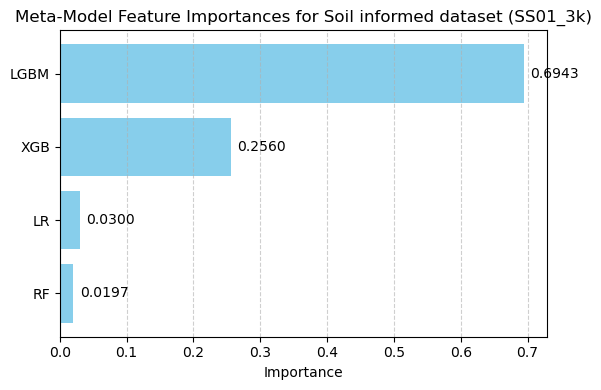

In [33]:
import matplotlib.pyplot as plt

# Feature importance values
importances = {
    'LGBM': 0.6943,
    'XGB': 0.2560,
    'LR': 0.0300,
    'RF': 0.0197
}

# Sort features by importance
sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_features)

# Plot
plt.figure(figsize=(6, 4))
bars = plt.barh(labels, values, color='skyblue')
plt.xlabel('Importance')
plt.title('Meta-Model Feature Importances for Soil informed dataset (SS01_3k)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Annotate values
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.4f}', va='center')

plt.tight_layout()
plt.show()


In [34]:
cv_results = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=outer_cv,
    scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'],
    return_train_score=False,
    n_jobs=-1
)


In [36]:
print("\nTRAINING SET CROSS-VALIDATION METRICS")
print("=" * 40)
for metric in ['accuracy', 'f1', 'precision', 'recall']:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper():>10}: {mean_score:.4f} ± {std_score:.4f}")



TRAINING SET CROSS-VALIDATION METRICS
  ACCURACY: 0.7961 ± 0.0221
        F1: 0.7852 ± 0.0396
 PRECISION: 0.8432 ± 0.0350
    RECALL: 0.7444 ± 0.0951



Plotting ROC-AUC Curve from Cross-Validated Training Predictions...


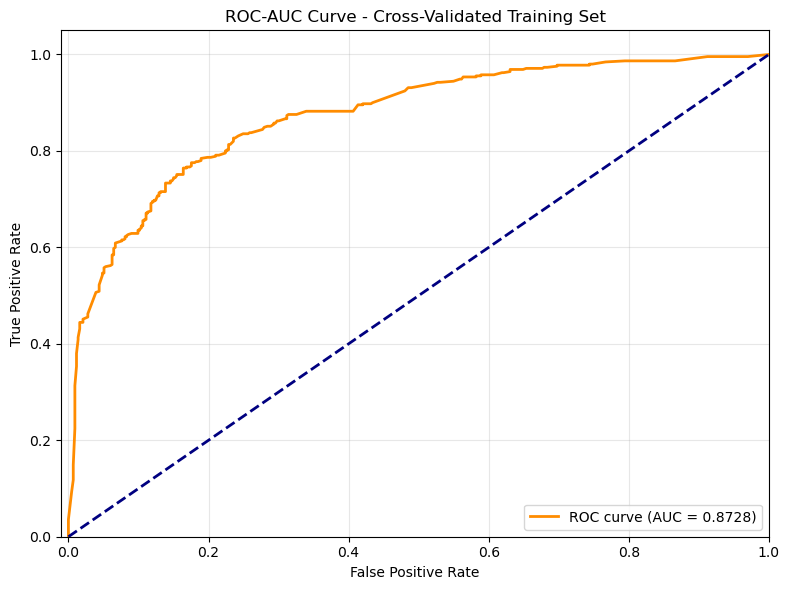

In [37]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
print("\nPlotting ROC-AUC Curve from Cross-Validated Training Predictions...")

# Get predicted probabilities (positive class) via CV
y_train_proba_cv = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=outer_cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]  # probability of class 1

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba_cv)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve - Cross-Validated Training Set')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
